In [2]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas as pd
import json
import re
from scipy import stats

import pingouin as pg

from statsmodels.stats.multicomp import pairwise_tukeyhsd

**Финальный срок сдачи: 16 апреля 21:00**

Вы работаете аналитиком в вертикале Недвижимость. Было решено развивать сегмент «Апартаменты» и
первыми продуктовыми инициативами запущенными в тест были:
- добавление чекбокса «Апартаменты в фильтр поиска;
- добавление быстрого фильтра в поиске:
    - «Однокомнатные апартаменты»
    - «Двухкомнатные апартаменты» и т.д.
- добавление планировки на карточку объявлений;
Для быстрой проверки гипотез было решено провести факторный эксперимент 
следующей конфигурации(одна строка — одна тестовая группа):
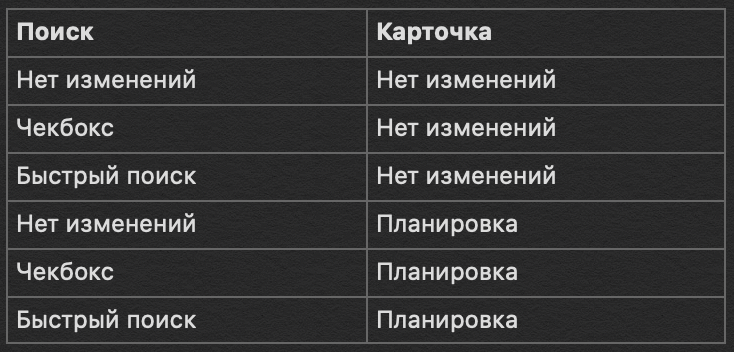


Есть гипотеза, что эти изменения приведут к росту конверсии из посетителя в покупателя.
Также есть дополнительная гипотеза о том, что изменения на поиске будут приводить к изменению структуры трафика на карточке и соответственно к изменению эффекта от улучшений на карточке.

Вам необходимо провести анализ эксперимента.

1. Сформирулируйте и формализуйте проверяемые продуктовые гипотезы. (2 балла)
2. Загрузите данные и постройте график распределений, по цвету раздели изменения на поиске, по строкам изменения на карточке. Попробуй проинтерпретировать изменения на основе визуального анализа. (2 балла)
3. Примени двухфакторную ANOVA и оцени изменения. (2 балла)
4. Примени критерий Тьюкки для нахождения парных изменений. (2 балла)
5. Сделайте продуктовые выводы по результатам эксперимента. (2 балла)


cookie_id - ид пользователя

split_group	- тестовая группа

searches - количество поисков

item_views - количество просмотров объявлений

changes_in_search - изменение в поиске

changes_in_item - изменение в на карточке


In [65]:
d=pd.read_csv('apartaments_dev.csv')

In [66]:
d.loc[d["contacts"] < 0 ] = 0 #Меняем отрицательные значения в contacts на 0
d = d[d.changes_in_search != 0] #Удаляем нули из changes_in_search

In [67]:
d.describe()

,cookie_id,searches,item_views,contacts
count,3.306808e+06,3.306808e+06,3.306808e+06,3.306808e+06
mean,3.452344e+12,3.699278e+01,3.229005e+01,1.063937e+00
std,8.080627e+11,1.676253e+02,1.478221e+02,9.705108e+00
min,7.293193e+08,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.415031e+12,2.000000e+00,2.000000e+00,0.000000e+00
50%,3.813392e+12,6.000000e+00,6.000000e+00,0.000000e+00
75%,3.923955e+12,2.100000e+01,2.200000e+01,0.000000e+00
max,3.967662e+12,7.153600e+04,4.184600e+04,3.579000e+03


In [68]:
#Разбиваем датасет на 6 тестовых групп

d_no_all = d[(d["changes_in_search"] == "no_changes") & (d["changes_in_item"] == "no_changes")]
d_checkbox = d[(d["changes_in_search"] == "checkbox") & (d["changes_in_item"] == "no_changes")]
d_fast = d[(d["changes_in_search"] == "fast_search") & (d["changes_in_item"] == "no_changes")]
d_plan = d[(d["changes_in_search"] == "no_changes") & (d["changes_in_item"] == "add_plan")]
d_check_plan = d[(d["changes_in_search"] == "checkbox") & (d["changes_in_item"] == "add_plan")]
d_fast_plan = d[(d["changes_in_search"] == "fast_search") & (d["changes_in_item"] == "add_plan")]

**Формулировка гипотез**

1) Добавление продуктовых инициатив в поиск снижает среднее число поисков (поскольку юзер находит быстрее именно то, что ему нужно) и увеличивает среднее число просмотров и заключенных сделок (опять же юзер с большей вероятностью наткнется на интересующее его объявление и будет доволен).
2) Добавление планировки должно влиять похожим образом: юзер быстрее находит интересующее его предложение по планировке, а значит не ищет дальше, снижая среднее число поисков, при этом чаще просматривает и заключает сделки.
3) Инициативы поиска и карточки должны иметь положительное воздействие друг на друга относительно числа просмотров и заключения сделок, и негативное в отношении числа поисков (то есть суммарно уменьшать число поисков).

При этом важнее всего число контактов - если пользователь чаще связывается с автором объявления, то он нашел то, что искал.

$H_0$: фичи поиска не влияют ни на число поисков, ни на просмотры, ни на контакты.

$H_0$: фича карточки не влияет ни на число поисков, ни на просмотры, ни на контакты.

$H_0$: нет взаимодействия между факторами. 


Проверим визуально, построив графики распределений.


(0.0, 1000.0)

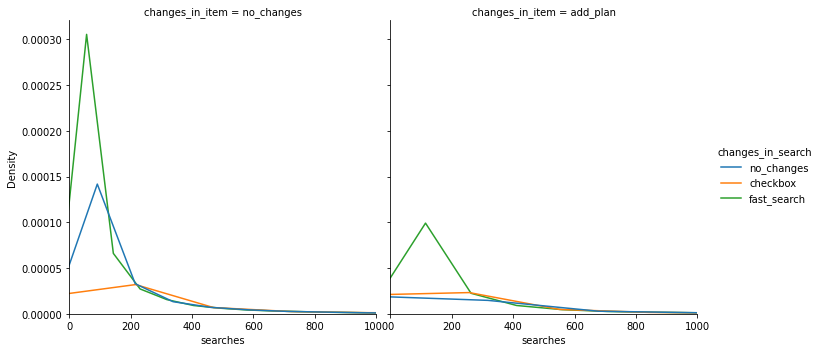

In [69]:
#Рисуем графики распределений, ограничиваем ось x при отображении
sns.displot(data = d, x = "searches", hue = "changes_in_search", col = "changes_in_item", kind = "kde")
plt.xlim(0, 1000)

Видим, что при обоих сценариях карточки быстрый поиск уменьшает число поисков (относительно случая, когда нет изменений в поиске), что согласуется с первой гипотезой. При этом чексбокс наоборот увеличивает (в противовес первой гипотезе). Также быстрый поиск имеет большую плотность для маленького числа поисков в случае, однако и отсутствие изменений в поиске также имеет там большую плотность - поэтому об эффекте взаимодействия сказать однозначно нельзя.

(0.0, 1000.0)

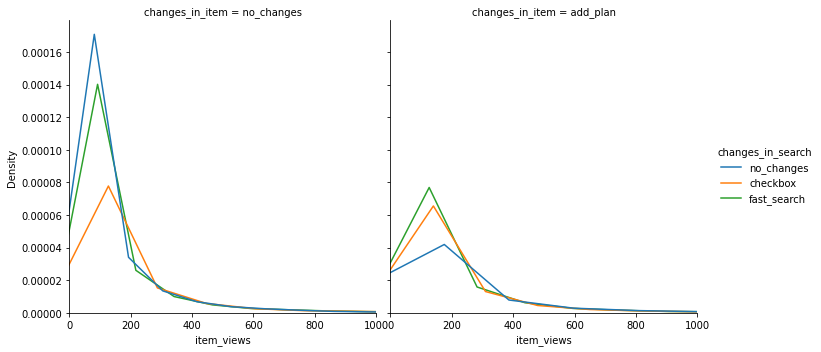

In [70]:
sns.displot(data = d, x = "item_views", hue = "changes_in_search", col = "changes_in_item", kind = "kde")
plt.xlim(0, 1000)

Видим, что в сценарии без планировки добавление фич в поиск приводит к тому, что распределение смещается в сторону большего числа просмотров. В случае добавления планировки происходит обратная картина (опять же сложно говорить о взаимодействии, однако при добавлении планировки график распределения противоречит гипотезе про поиск, без планировки - соответствует).

(0.0, 50.0)

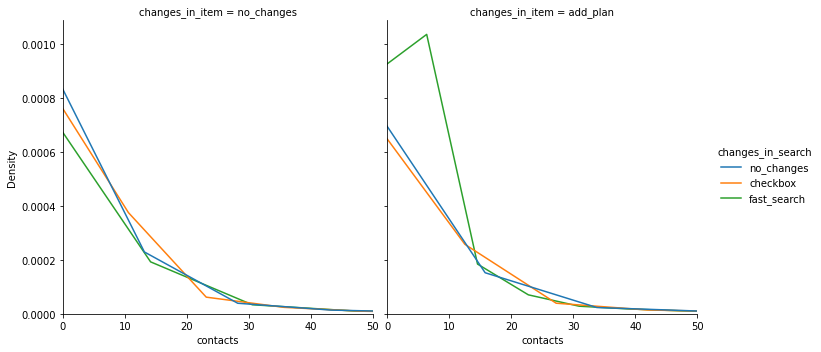

In [73]:
sns.displot(data = d, x = "contacts", hue = "changes_in_search", col = "changes_in_item", kind = "kde")
plt.xlim(0, 50)

Без планировки число контактов увеличивается с добавлением фич в поиск; с планировкой картина неоднозначная для чекбокса, быстрый поиск показывает, что у него много как нулей контактов, так и небольшого числа (если первое - минус, второе - однозначно плюс). Таким образом, визуальный анализ, с одной стороны, подтверждает некоторые гипотезы, с другой, мало говорит о взаимодействии фич поиска и карточки, а также местами идет вразрез с выдвинутыми предположениями. Проверим формально двухфакторным дисперсионным анализом.

In [74]:
aov = pg.anova(dv="searches", between=["changes_in_search","changes_in_item"], data=d, detailed=True)
print(aov)

                                Source            SS         DF            MS  \
0                    changes_in_search  7.220296e+04        2.0  36101.480355   
1                      changes_in_item  2.586286e+04        1.0  25862.858590   
2  changes_in_search * changes_in_item  6.768148e+04        2.0  33840.740318   
3                             Residual  9.291532e+10  3306802.0  28098.240349   

          F     p-unc           np2  
0  1.284831  0.276698  7.770829e-07  
1  0.920444  0.337358  2.783486e-07  
2  1.204372  0.299880  7.284206e-07  
3       NaN       NaN           NaN  


In [75]:
aov = pg.anova(dv="item_views", between=["changes_in_search","changes_in_item"], data=d, detailed=True)
print(aov)

                                Source            SS         DF  \
0                    changes_in_search  3.433501e+05        2.0   
1                      changes_in_item  9.411296e+01        1.0   
2  changes_in_search * changes_in_item  2.173298e+05        2.0   
3                             Residual  7.225767e+10  3306802.0   

              MS         F     p-unc           np2  
0  171675.050188  7.856542  0.000387  4.751724e-06  
1      94.112961  0.004307  0.947674  1.302463e-09  
2  108664.885375  4.972943  0.006923  3.007696e-06  
3   21851.222625       NaN       NaN           NaN  


In [76]:
aov = pg.anova(dv="contacts", between=["changes_in_search","changes_in_item"], data=d, detailed=True)
print(aov)

                                Source            SS         DF           MS  \
0                    changes_in_search  3.291080e+03        2.0  1645.540201   
1                      changes_in_item  9.781351e+02        1.0   978.135071   
2  changes_in_search * changes_in_item  5.791502e+00        2.0     2.895751   
3                             Residual  3.114609e+08  3306802.0    94.187962   

           F         p-unc           np2  
0  17.470812  2.585608e-08  1.056648e-05  
1  10.384927  1.270495e-03  3.140464e-06  
2   0.030744  9.697234e-01  1.859463e-08  
3        NaN           NaN           NaN  


Видим, что влияние на число поисков незначимо. Изменения в поиске значимо влияют и на число просмотров, и на число контактов (альфа = 0.01), при этом в случае просмотров есть взаимный эффект с фичами карточки. Для контактов есть значимый эффект влияния и поиска, и карточки, но не вместе.

In [77]:
print(pairwise_tukeyhsd(endog=d['searches'], groups=d['changes_in_search'], alpha=0.01))

     Multiple Comparison of Means - Tukey HSD, FWER=0.01     
   group1      group2   meandiff p-adj   lower  upper  reject
-------------------------------------------------------------
   checkbox fast_search  -0.3316 0.3058 -0.9886 0.3254  False
   checkbox  no_changes  -0.0416    0.9 -0.6999 0.6167  False
fast_search  no_changes     0.29 0.4061 -0.3683 0.9483  False
-------------------------------------------------------------


In [78]:
print(pairwise_tukeyhsd(endog=d['searches'], groups=d['changes_in_item'], alpha=0.01))

   Multiple Comparison of Means - Tukey HSD, FWER=0.01   
 group1    group2   meandiff p-adj   lower  upper  reject
---------------------------------------------------------
add_plan no_changes  -0.1764 0.3387 -0.6513 0.2985  False
---------------------------------------------------------


Видим, что в числе поисков нет влияния в попарных сравнениях как для фич поиска, так и для фич карточки.

In [79]:
print(pairwise_tukeyhsd(endog=d['item_views'], groups=d['changes_in_search'], alpha=0.01))

     Multiple Comparison of Means - Tukey HSD, FWER=0.01      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
   checkbox fast_search  -0.4896 0.0368  -1.069  0.0898  False
   checkbox  no_changes  -0.7812  0.001 -1.3617 -0.2007   True
fast_search  no_changes  -0.2915 0.3093 -0.8721   0.289  False
--------------------------------------------------------------


In [81]:
print(pairwise_tukeyhsd(endog=d['item_views'], groups=d['changes_in_item'], alpha=0.01))

  Multiple Comparison of Means - Tukey HSD, FWER=0.01   
 group1    group2   meandiff p-adj  lower  upper  reject
--------------------------------------------------------
add_plan no_changes   0.0088   0.9 -0.4099 0.4276  False
--------------------------------------------------------


Чекбокс значимо уменьшает число просмотров по сравнению с отстуствием фич; возможно, что это не так плохо само по себе, если чекбокс увеличивает число контактов (если нашли нужное объявление и связались раньше - в целом просматриваем объявления меньше).

In [80]:
print(pairwise_tukeyhsd(endog=d['contacts'], groups=d['changes_in_search'], alpha=0.01))

     Multiple Comparison of Means - Tukey HSD, FWER=0.01      
   group1      group2   meandiff p-adj   lower   upper  reject
--------------------------------------------------------------
   checkbox fast_search  -0.0336 0.0275 -0.0716  0.0045  False
   checkbox  no_changes  -0.0773  0.001 -0.1154 -0.0391   True
fast_search  no_changes  -0.0437 0.0024 -0.0818 -0.0056   True
--------------------------------------------------------------


In [82]:
print(pairwise_tukeyhsd(endog=d['contacts'], groups=d['changes_in_item'], alpha=0.01))

   Multiple Comparison of Means - Tukey HSD, FWER=0.01    
 group1    group2   meandiff p-adj   lower   upper  reject
----------------------------------------------------------
add_plan no_changes  -0.0346 0.0012 -0.0621 -0.0071   True
----------------------------------------------------------


Все фичи значимо уменьшают число контактов по сравнению с их отстуствием. Это явно не тот продуктовый результат, который в итоге ожидался.

**Выводы**

По тестам мы видим, что продуктовые изменения либо влияют незначимо, либо ухудшают ключевые показатели (число контактов), поэтому либо стоить изучить влияние подробнее (повлияли ли, например, сезонные факторы), либо не раскатывать изменения на всех пользователях.